In [2]:
import numpy as np
import os
from package.Graphs import Graphs
import ast
import math
import pandas as pd
np.set_printoptions(threshold=np.inf)
from scipy.linalg import inv, sqrtm
import seaborn as sns
import matplotlib.pyplot as plt

def mahalanobis_distance(mu1, sigma1, mu2, sigma2):
    # Calculate the Mahalanobis distance between two Gaussian components

    # Step 1: Compute mean vectors
    mean_diff = mu1 - mu2

    # Step 2: Compute covariance matrices
    cov_sum = sigma1 + sigma2

    # Step 3: Calculate the inverse of the covariance matrix
    cov_inv = inv(cov_sum)

    # Step 4: Calculate Mahalanobis distance
    mahalanobis_dist = np.sqrt(mean_diff @ cov_inv @ mean_diff.T)

    return mahalanobis_dist

## Analysis for old QubiC Q3 Data (2021) (1 GSPS)

In [ ]:
# Load Data 
state0=np.load('../Data/2021/Q3/state0.npy') #(128,4096,2)
state1=np.load('../Data/2021/Q3/state1.npy') 

# Seperate I and Q
state0_I,state0_Q = state0[:,:,0],state0[:,:,1]  #(128,4096)
state1_I,state1_Q = state1[:,:,0],state1[:,:,1]


# Mean across shots
shotsMean0_I,shotsMean0_Q = np.mean(state0_I,axis=0),np.mean(state0_Q,axis=0) #(4096)
shotsMean1_I,shotsMean1_Q = np.mean(state1_I,axis=0),np.mean(state1_Q,axis=0)

In [ ]:
# Call Ploting function on Orignial Signal
window=100 #For Moving Average
fig=Graphs.plotSignals(shotsMean0_I,shotsMean0_Q,shotsMean1_I,shotsMean1_Q,lo=0,hi=4096,window_size=window)
fig.show()

In [ ]:
# Get and plot Readout Frequency
frequency,amplitude,phase=Graphs.getFFT(shotsMean0_Q,1000000000)
index = np.where(amplitude==np.max(amplitude))[0]
if phase[index]>=0:
    sign='+'
else:
    sign='-'
print(sign,frequency[index][0],"Hz")
fig=Graphs.plotFFT(frequency,amplitude)
fig.show()

In [ ]:
#Rotate the Orignal signal with signal of readout frequency

# Construct rotating signal
readout_freq=-17597366.299644876
rot=Graphs.getComplexSignal(readout_freq,1,0,4096,1,phase=0,t0=0)  #(4096)

#Rotate og signal and convert the into complex signals
state0_complex=(state0_I+1j*state0_Q)*rot  #(128,4096)
state1_complex=(state1_I+1j*state1_Q)*rot

# Mean Across complex shots
shotsmean0_complex=np.mean(state0_complex,axis=0) #(4096)
shotsmean1_complex=np.mean(state1_complex,axis=0)


shotsStd0_I=np.std(state0_complex.real,axis=0)/100 #(4096)
shotsStd1_I=np.std(state1_complex.real,axis=0)/100 
shotsStd0_Q=np.std(state0_complex.imag,axis=0)/100
shotsStd1_Q=np.std(state1_complex.imag,axis=0)/100

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = state0_complex[:,1500].real.reshape((128))  # Replace with your own data
print(shotsmean0_complex[1500])
# Create a histogram
plt.hist(data, bins=20, edgecolor='k', alpha=0.7)  # 'bins' sets the number of bins

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

In [ ]:
# Smooth out complex signal and get I and Q component from complex signal
smooth0_I,smooth0_Q,smooth1_I,smooth1_Q=Graphs.ewmaComplexSignals(shotsmean0_complex , shotsmean1_complex, alpha=0.1)  #(4096)

# Smooth out standard Deviation of I and Q component.
# smoothStd0_I,smoothStd0_Q,smoothStd1_I,smoothStd1_Q=Graphs.ewmaSignals(shotsStd0_I,shotsStd0_Q,shotsStd1_I,shotsStd1_Q, alpha=0.00001)
# # # Plot trajectory
# fig=Graphs.plotTrajectoryError(smooth0_I,smooth0_Q,
#                                smooth1_I,smooth1_Q,
#                                smoothStd0_I,smoothStd0_Q,
#                                smoothStd1_I,smoothStd1_Q,
#                                1000,2700,50) #700ns proper trajectory seperation
# fig.show()

fig=Graphs.plotTrajectory(smooth0_I,smooth0_Q,
                          smooth1_I,smooth1_Q,
                          1000,2700,50) #700ns proper trajectory seperation
fig.show()

In [ ]:
# Integration across time for each shots
st,en=100,2500   #Best result 1200ns to 2500ns but result from 1200ns to 1500ns is comparable too.
sum0_complex=np.mean(state0_complex[:,st:en],axis=1) #(128)
sum1_complex=np.mean(state1_complex[:,st:en],axis=1) 
# Plot cluster
fig=Graphs.plotCluster(sum0_complex.real,sum0_complex.imag,sum1_complex.real,sum1_complex.imag)
fig.show()

In [ ]:
# Weighted integration across time for each shots
st,en=100,2500
weight_I=np.transpose(abs(smooth0_I-smooth1_I))
weight_Q=np.transpose(abs(smooth0_Q-smooth1_Q))
print(weight_I.shape)
weightedSum0_I=np.mean(np.real(state0_complex[:,st:en])*weight_I[st:en],axis=1)
weightedSum0_Q=np.mean(np.imag(state0_complex[:,st:en])*weight_Q[st:en],axis=1)
weightedSum1_I=np.mean(np.real(state1_complex[:,st:en])*weight_I[st:en],axis=1)
weightedSum1_Q=np.mean(np.imag(state1_complex[:,st:en])*weight_Q[st:en],axis=1)

fig=Graphs.plotCluster(weightedSum0_I,weightedSum0_Q,weightedSum1_I,weightedSum1_Q)
fig.show()

## Analysis for new QubiC Data (2023) (2 GSPS)

In [ ]:
# Load Data 
# state0=np.load('../Data/hd_data/test_decimator0_state0/arr_0.npy')[:,:8192] #(1000,8192)
# state1=np.load('../Data/hd_data/test_decimator0_state1/arr_0.npy')[:,:8192]

#Load Neel's Data
# state0=np.load('../Data/neel_readout/Q1_2us/state0.npy')[:,:8192]
# state1=np.load('../Data/neel_readout/Q1_2us/state1.npy')[:,:8192]

state0=np.load('../Data/new/2gsps/state0.npy')[:,:8192]
state1=np.load('../Data/new/2gsps/state1.npy')[:,:8192]


# Mean across shots
shotsMean0= np.mean(state0,axis=0) #(8192)
shotsMean1= np.mean(state1,axis=0)

# print(shotsMean0.shape)

fig=Graphs.plotSignal(shotsMean0[10:,0],lo=10,hi=8192,step=0.5)
fig.show()

fig=Graphs.plotSignal(shotsMean1[10:,0],lo=10,hi=8192,step=0.5)
fig.show()

In [ ]:
# Get and plot Readout Frequency
frequency,amplitude,phase=Graphs.getFFT(shotsMean0[10:],2000000000) #Try slicing out first 10ns
index = np.where(amplitude==np.max(amplitude))[0]
print(phase[index])
if phase[index,0]>=0:
    sign='+'
else:
    sign='-' 
print(sign,frequency[index][0],"Hz")
fig=Graphs.plotFFT(frequency,amplitude)
fig.show()

In [ ]:
#Rotate the Orignal signal with signal of readout frequency

# Construct rotating signal
# Q1 6558500000.003296
# q0 6554298629.445268
readout_freq=669274016.1329747
dlo=Graphs.getComplexSignal(readout_freq,0,4096,0.5) #(8192)


#Rotate og signal and convert the into complex signals
state0_complex=((state0+0j)*dlo) #(1000,8192)
state1_complex=((state1+0j)*dlo)

# fig=Graphs.plotSignals(np.mean(state0_complex[:,10:],axis=0).real,np.mean(state1_complex[:,10:],axis=0).real,np.mean(state0_complex[:,10:],axis=0).imag,np.mean(state1_complex[:,10:],axis=0).imag,0,4096,100,0.5)
# fig.show()

fig=Graphs.plotSignal(state0_complex[1,700:3700].imag,lo=0,hi=3000,step=0.5)
fig.show()

state0_save=np.stack((state0_complex.real,state0_complex.imag),axis=2)
state1_save=np.stack((state1_complex.real,state1_complex.imag),axis=2)
np.save('../Data/new/2gsps/state0.npy',state0_save)
np.save('../Data/new/2gsps/state1.npy',state1_save)
# Mean Across complex shots
shotsmean0_complex=np.mean(state0_complex,axis=0) #(8192)
shotsmean1_complex=np.mean(state1_complex,axis=0)

shotsStd0_I=np.std(state0_complex[3:].real,axis=0) #(8192)
shotsStd1_I=np.std(state1_complex[3:].real,axis=0)
shotsStd0_Q=np.std(state0_complex[3:].imag,axis=0)
shotsStd1_Q=np.std(state1_complex[3:].imag,axis=0)

# np.set_printoptions(threshold=np.inf)
# shotsStd0_I

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(state0_complex.shape)
data = state0_complex[:,2700].real.reshape((6000)) 
print(data.shape)
print(shotsmean0_complex[2700])
# Create a histogram
plt.hist(data, bins=20, edgecolor='k', alpha=0.7)  # 'bins' sets the number of bins

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

In [ ]:
print(state0.shape)
state0_complex = state0[:,:,0] + 1j*state0[:,:,1]
print(state0_complex.shape)
print(state1.shape)
state1_complex = state1[:,:,0] + 1j*state1[:,:,1]
print(state1_complex.shape)

In [ ]:
# Smooth out complex signal and get I and Q component from complex signal
smooth0_I,smooth0_Q,smooth1_I,smooth1_Q=Graphs.ewmaComplexSignals(shotsmean0_complex[3:] , shotsmean1_complex[3:], alpha=200)  #(8189)
# # Smooth out standard Deviation of I and Q component.
# smoothStd0_I,smoothStd0_Q,smoothStd1_I,smoothStd1_Q=Graphs.ewmaSignals(shotsStd0_I,shotsStd0_Q,shotsStd1_I,shotsStd1_Q, alpha=100)
# # Plot trajectory
# fig=Graphs.plotTrajectoryError(smooth0_I,smooth0_Q,
#                                smooth1_I,smooth1_Q,
#                                smoothStd0_I,smoothStd0_Q,
#                                smoothStd1_I,smoothStd1_Q,
#                                700,2700,50) #700ns proper trajectory seperation
# fig.show()

fig=Graphs.plotTrajectory(smooth0_I,smooth0_Q,
                          smooth1_I,smooth1_Q,
                          700,2700,50) #700ns proper trajectory seperation
fig.show()


fig=Graphs.plotTrajectory(shotsmean0_complex[3:].real,shotsmean0_complex[3:].imag,
                         shotsmean1_complex[3:].real,shotsmean1_complex[3:].imag,
                          700,2700,50) #700ns proper trajectory seperation
fig.show()

In [ ]:
# Integration across time for each shots
st,en=0,2700  #clear seperation from 2000 to 3000 ie. 1µs to 1.5µs
sum0_complex=np.sum(state0_complex[:,st:en],axis=1) #(1000)
sum1_complex=np.sum(state1_complex[:,st:en],axis=1) 
# Plot cluster
fig=Graphs.plotCluster(sum0_complex.real,sum0_complex.imag,sum1_complex.real,sum1_complex.imag)
fig.show()

centroid0=sum0_complex.mean()
centroid1=sum1_complex.mean()
point0=np.array([centroid0.real,centroid0.imag])
point1=np.array([centroid1.real,centroid1.imag])
dist_normal = math.dist(point0 , point1)
print(dist_normal)


In [ ]:
##Fig

# Define st and en
st, en = 0, 4700

# Calculate sums
sum0_complex = np.sum(state0_complex[:, st:en], axis=1)
sum1_complex = np.sum(state1_complex[:, st:en], axis=1)

# Calculate mean of each cluster
mean0_complex = np.mean(sum0_complex)
mean1_complex = np.mean(sum1_complex)

# Define lighter color palette
lighter_blue = (0.7, 0.7, 1.0)
lighter_orange = (1.0, 0.85, 0.7)

# Plot points with lighter colors
plt.scatter(sum0_complex.real, sum0_complex.imag, color=lighter_blue, alpha=0.1)
plt.scatter(sum1_complex.real, sum1_complex.imag, color=lighter_orange, alpha=0.1)

# Highlight mean of each cluster with a brighter color
plt.scatter(mean0_complex.real, mean0_complex.imag, color=(0.7, 0.55, 0.8), marker='o', label='State0')
plt.scatter(mean1_complex.real, mean1_complex.imag, color='orange', marker='o', label='State1')

plt.xlabel('I',fontsize=12)
plt.ylabel('Q',fontsize=12)
# plt.legend(fontsize='large')

plt.axis('off')  # Remove axis
plt.gcf().set_facecolor('none')
plt.savefig('images/Q1.svg', dpi=500,transparent=True)
plt.show()

In [ ]:
cluster0=np.array([sum0_complex.real,sum0_complex.imag])
cluster1=np.array([sum1_complex.real,sum1_complex.imag])
print(np.cov(cluster0).shape)


# Example usage
mu1 = point0
sigma1 = np.cov(cluster0)
print(mu1.shape)
mu2 = point1
sigma2 = np.cov(cluster1)

distance = mahalanobis_distance(mu1, sigma1, mu2, sigma2)
print(f"Mahalanobis Distance: {distance}")


In [ ]:
st,en=3,3700
readout_freq=6558500000.003296
smooth0_I,smooth0_Q,smooth1_I,smooth1_Q=Graphs.ewmaComplexSignals(shotsmean0_complex[st:en] , shotsmean1_complex[st:en], alpha=100)
weight_I=np.transpose(abs(smooth0_I-smooth1_I))
weight_Q=np.transpose(abs(smooth0_Q-smooth1_Q))
print(weight_I.shape)
maxI,maxQ=weight_I.max(),weight_Q.max()
weight_I,weight_Q=weight_I/maxI,weight_Q/maxQ
dlo=Graphs.getComplexSignal(readout_freq,0,4096,0.5)
dlo_weighted=dlo[st:en].real*weight_I + dlo[st:en].imag*weight_Q*1j


state0_complex=((state0+0j)[:,st:en]*dlo_weighted) #(1000,8192)
state1_complex=((state1+0j)[:,st:en]*dlo_weighted)

weightedSum0_I=np.sum(np.real(state0_complex),axis=1)
weightedSum0_Q=np.sum(np.imag(state0_complex),axis=1)
weightedSum1_I=np.sum(np.real(state1_complex),axis=1)
weightedSum1_Q=np.sum(np.imag(state1_complex),axis=1)
fig=Graphs.plotCluster(weightedSum0_I,weightedSum0_Q,weightedSum1_I,weightedSum1_Q)
fig.show()


point0=np.array([weightedSum0_I.mean(),weightedSum0_Q.mean()])
point1=np.array([weightedSum1_I.mean(),weightedSum1_Q.mean()])
dist_weighted = math.dist(point0 , point1)
print(dist_weighted)

cluster0=np.array([weightedSum0_I,weightedSum0_Q])
cluster1=np.array([weightedSum1_I,weightedSum1_Q])
print(np.cov(cluster0).shape)
# Example usage
mu1 = point0
sigma1 = np.cov(cluster0)
print(mu1.shape)
mu2 = point1
sigma2 = np.cov(cluster1)

distance = mahalanobis_distance(mu1, sigma1, mu2, sigma2)
print(f"Mahalanobis Distance: {distance}")

In [ ]:
# Weighted integration across time for each shots
st,en=700,3700

# print(smooth0_I.shape,shotsmean0_complex[3:].shape)
# weight_I=np.transpose(abs(shotsmean0_complex[3:].real-shotsmean1_complex[3:].real))
# weight_Q=np.transpose(abs(shotsmean0_complex[3:].imag-shotsmean1_complex[3:].imag))
# print(weight_I.shape)

weight_I=np.transpose(abs(smooth0_I-smooth1_I))
weight_Q=np.transpose(abs(smooth0_Q-smooth1_Q))
print(weight_I.shape)

weightedSum0_I=np.mean(np.real(state0_complex[:,st:en])*weight_I[st:en],axis=1)
weightedSum0_Q=np.mean(np.imag(state0_complex[:,st:en])*weight_Q[st:en],axis=1)
weightedSum1_I=np.mean(np.real(state1_complex[:,st:en])*weight_I[st:en],axis=1)
weightedSum1_Q=np.mean(np.imag(state1_complex[:,st:en])*weight_Q[st:en],axis=1)
fig=Graphs.plotCluster(weightedSum0_I,weightedSum0_Q,weightedSum1_I,weightedSum1_Q)
fig.show()

In [ ]:
readout_freq=6558500000.003296
dlo=Graphs.getComplexSignal(readout_freq,0,4096,0.5)
print(weight_I[5])
print(weight_Q[5])
print(dlo[1])
print(dlo[1].real*2 + dlo[1].imag*3*1j)


### Remove outliers

In [ ]:
# Find error point
l0_1=[]
l1_0=[]
print(sum0_complex.shape[0])
for i in range(sum0_complex.shape[0]):
    point=np.array([sum0_complex[i].real,sum0_complex[i].imag])
    point0=np.array([centroid0.real,centroid0.imag])
    point1=np.array([centroid1.real,centroid1.imag])
    dist0 = math.dist(point , point0)
    dist1 = math.dist(point , point1)
    if (dist0+0)<dist1:
        # l0_1.append(sum0_complex[i])
        l0_1.append(i)
for i in range(sum1_complex.shape[0]):
    point=np.array([sum1_complex[i].real,sum1_complex[i].imag])
    point0=np.array([centroid0.real,centroid0.imag])
    point1=np.array([centroid1.real,centroid1.imag])
    dist0 = math.dist(point , point0)
    dist1 = math.dist(point , point1)
    if dist0>(dist1+0):
        # l1_0.append(sum1_complex[i])
        l1_0.append(i)
print(len(l0_1),len(l1_0))

In [ ]:
state0_herhalded,state1_herhalded=[],[]
for i in l0_1:
    state0_herhalded.append(state0_complex[i])
for i in l1_0:
    state1_herhalded.append(state1_complex[i])
state0_herhalded=np.array(state0_herhalded)
state1_herhalded=np.array(state1_herhalded)
print(state0_herhalded.shape,state1_herhalded.shape)


state0_save=np.stack((state0_herhalded.real,state0_herhalded.imag),axis=2)
state1_save=np.stack((state1_herhalded.real,state1_herhalded.imag),axis=2)
np.save('../Data/new/2gsps/Q0state0_her.npy',state0_save)
np.save('../Data/new/2gsps/Q0state1_her.npy',state1_save)

In [ ]:
# Integration across time for each shots
st,en=700,3700  #clear seperation from 2000 to 3000 ie. 1µs to 1.5µs
sum0_complex=np.mean(state0_herhalded[:,st:en],axis=1) #(1000)
sum1_complex=np.mean(state1_herhalded[:,st:en],axis=1) 
# Plot cluster
fig=Graphs.plotCluster(sum0_complex.real,sum0_complex.imag,sum1_complex.real,sum1_complex.imag)
fig.show()

centroid0=sum0_complex.mean()
centroid1=sum1_complex.mean()

In [ ]:
fig=Graphs.plotSignal(np.abs(shotsmean0_complex.real[3:] - shotsmean1_complex[3:].real),lo=0,hi=8192,step=0.5)
fig.show()

fig=Graphs.plotSignal(np.abs(shotsmean0_complex.imag[3:] - shotsmean1_complex[3:].imag),lo=0,hi=8192,step=0.5)
fig.show()

fig=Graphs.plotSignal(weight_I,lo=0,hi=8192,step=0.5)
fig.show()

fig=Graphs.plotSignal(weight_Q,lo=0,hi=8192,step=0.5)
fig.show()



## Weighted DLO

In [ ]:
#Load Neel's Data

state0=np.load("../Data/neel_readout/011024/Q3_raw_state0.npy")
state1=np.load("../Data/neel_readout/011024/Q3_raw_state1.npy")

# state0=np.load("../Data/neel_readout/030124/Q2_raw_state0.npy")
# state1=np.load("../Data/neel_readout/030124/Q2_raw_state1.npy")

# state0_1=np.load("../Data/neel_readout/030124/Q1_raw_state0_V1.npy")
# state1_1=np.load("../Data/neel_readout/030124/Q1_raw_state1_V1.npy")
# state0=np.vstack((state0,state0_1))
# state1=np.vstack((state1,state1_1))
print(state0.shape, state1.shape)
shotsMean0= np.mean(state0,axis=0) #(8192)
shotsMean1= np.mean(state1,axis=0)
# print(state0)
fig=Graphs.plotSignal(shotsMean0[10:],lo=10,hi=8192,step=0.5)
fig.show()

fig=Graphs.plotSignal(shotsMean1[10:],lo=10,hi=8192,step=0.5)
fig.show()

In [ ]:
# 6 558 950 000
'''
Q1: 6558994494.03787, 20278, 1.8643461140557456
Q2: 6658371267.87147, 20210  1.95287363507295
Q1_old : 6699324335.796245, 20105 ,6.173789022938911
'''
frequencies=6699324335.796245
samples_per_clk=16
st = 20105 #Vary from circuit to circuit
CSTROBE_DELAY=2
QCLK_DELAY=4
PHASEIN_DELAY=1
phase=6.173789022938911
CLK_CYCLE=2
PHASE_RST_DELAY=9
start_time = samples_per_clk*st + samples_per_clk*(CSTROBE_DELAY + QCLK_DELAY + PHASEIN_DELAY)
phases = phase + 2*np.pi*(CLK_CYCLE/samples_per_clk)\
        *1.e-9*(start_time - samples_per_clk*(PHASE_RST_DELAY))*frequencies

print(phases)
amplitude=1 #1/1.64676025812107
dlo=Graphs.getComplexSignal(frequencies,amplitude,st=0,end=4096,step=0.5,phase=phases,t0=0) #(8192)
dlo_int=np.ceil(dlo.real*((2**15)-1)) + 1j*(np.ceil(dlo.imag*((2**15)-1)))
# print(dlo_int)

#Rotate og signal and convert the into complex signals
state0_complex=((state0+0j)*dlo_int) #(1000,8192)
state1_complex=((state1+0j)*dlo_int)

fig=Graphs.plotSignal(dlo_int.real,lo=10,hi=1024,step=0.5)
fig.show()

# acq_dlo=np.load('../Data/neel_readout/121323/dlo_2µs_0.25_acq.npy')[0,(320*2):]
# acq2_dlo=np.load('../Data/neel_readout/121323/dlo2_2µs_0.25_acq.npy')[0,(320*2):]


print(dlo_int.real.max(),dlo_int.imag.max())
# print(acq_dlo.max(),acq2_dlo.max())
print(dlo_int.real.min(),dlo_int.imag.min())
# print(acq_dlo.min(),acq2_dlo.min())



# fig=Graphs.plotSignals(dlo_int.real,acq_dlo,dlo_int.imag,acq2_dlo,lo=0,hi=200,window_size=100,steps=0.5)
# fig.show()
# fig=Graphs.plotSignals(tmp,tmp2,acq_dlo,acq2_dlo,lo=0,hi=4096,window_size=100,steps=0.5)
# fig.show()



### plot Traj

In [ ]:
from scipy import stats
def trace(s0I,s0Q,s1I,s1Q,st,ed,window):
    trc0I=np.add.reduceat(s0I[st:ed], range(0,ed-st,window),axis=0)/float(window)
    trc0Q=np.add.reduceat(s0Q[st:ed], range(0,ed-st,window),axis=0)/float(window)
    trc1I=np.add.reduceat(s1I[st:ed], range(0,ed-st,window),axis=0)/float(window)
    trc1Q=np.add.reduceat(s1Q[st:ed], range(0,ed-st,window),axis=0)/float(window)
    return trc0I,trc0Q,trc1I,trc1Q
shotsmean0_complex=np.mean(state0_complex,axis=0) #(8192)
shotsmean1_complex=np.mean(state1_complex,axis=0)

# Standard Deviation
shotstd0_complex=np.std(state0_complex.real,axis=0) + 1j*(np.std(state0_complex.imag,axis=0)) #(8192)
shotstd1_complex=np.std(state1_complex.real,axis=0) + 1j*(np.std(state1_complex.imag,axis=0))
# Standard Error
shotstd0_complex=stats.sem(state0_complex.real) + 1j*(stats.sem(state0_complex.real))
shotstd1_complex=stats.sem(state1_complex.real) + 1j*(stats.sem(state1_complex.real))

smooth0_I,smooth0_Q,smooth1_I,smooth1_Q=Graphs.ewmaComplexSignals(shotsmean0_complex[3:] , shotsmean1_complex[3:], alpha=100) 
smoothStd0_I,smoothStd0_Q,smoothStd1_I,smoothStd1_Q=Graphs.ewmaComplexSignals(shotstd0_complex[3:] , shotstd1_complex[3:], alpha=100) 

# print(shotsmean0_complex[2600],shotstd0_complex[2600])
# print(shotsmean1_complex[2600],shotstd1_complex[2600])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

# Generate some sample data for state0 and state1
trc0I, trc0Q, trc1I, trc1Q = trace(smooth0_I, smooth0_Q, smooth1_I, smooth1_Q, 680, 2680, 100)
std0I, std0Q, std1I, std1Q = trace(smoothStd0_I, smoothStd0_Q, smoothStd1_I, smoothStd1_Q, 680, 2680, 100)

# Define light orange color (RGB values)
light_orange = (1.0, 0.8, 0.5)  # Red: 1.0, Green: 0.8, Blue: 0.5

# Plot the trajectories
plt.plot(trc0I, trc0Q, marker='o', linestyle='-', color=(0.7, 0.65, 0.8), label='State 0')
plt.plot(trc1I, trc1Q, marker='o', linestyle='-', color=light_orange, label='State 1')

# Function to draw ellipse
def draw_ellipse(ax, center, width, height, angle, color):
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle,
                      edgecolor='none', facecolor=color, alpha=0.2)
    ax.add_patch(ellipse)

# Draw ellipses around the error bars
for i in range(len(trc0I)):
    draw_ellipse(plt.gca(), (trc0I[i], trc0Q[i]), 2*std0I[i], 2*std0Q[i], 0, (0.7, 0.7, 1.0))

for i in range(len(trc1I)):
    draw_ellipse(plt.gca(), (trc1I[i], trc1Q[i]), 2*std1I[i], 2*std1Q[i], 0, (1.0, 0.85, 0.7))

plt.xlabel('I', fontsize=13)
plt.ylabel('Q', fontsize=13)
plt.title('State Trajectories with Standard Error')
plt.legend(loc='lower left', fontsize='large',framealpha=0.1)
plt.savefig('images/state_trajectories_with_error.svg', dpi=1000, transparent=True)
plt.show()


### clusters w/o weights

In [ ]:
# Define st and en
st, en = 740, 2740

# Calculate sums
sum0_complex = np.sum(state0_complex[:, st:en], axis=1)
sum1_complex = np.sum(state1_complex[:, st:en], axis=1)

# Calculate mean of each cluster
mean0_complex = np.mean(sum0_complex)
mean1_complex = np.mean(sum1_complex)

# Define lighter color palette
lighter_blue = (0.7, 0.7, 1.0)
lighter_orange = (1.0, 0.85, 0.7)

# Plot points with lighter colors
plt.scatter(sum0_complex.real, sum0_complex.imag, color=lighter_blue, alpha=0.1)
plt.scatter(sum1_complex.real, sum1_complex.imag, color=lighter_orange, alpha=0.1)

# Highlight mean of each cluster with a brighter color
plt.scatter(mean0_complex.real, mean0_complex.imag, color=(0.7, 0.55, 0.8), marker='o', label='State0')
plt.scatter(mean1_complex.real, mean1_complex.imag, color='orange', marker='o', label='State1')

plt.xlabel('I')
plt.ylabel('Q')
# plt.legend(fontsize='large')

plt.axis('off')  # Remove axis
plt.gcf().set_facecolor('none')
plt.savefig('images/cluster with dlo.png', dpi=500,transparent=True)
plt.show()

### Plot weigth

In [ ]:

t=np.arange(0*1e-9, 1100*1e-9, 0.5*1e-9)
plt.plot(t,weight_complex[600:2800].real, linestyle='-', color='lightblue', linewidth=2, label='I')
plt.plot(t,weight_complex[600:2800].imag, linestyle='-', color=light_orange, linewidth=2, label='Q')
plt.grid(True)
plt.legend(loc='upper left',fontsize='large')
plt.savefig('weight_complex.png', dpi=500)
plt.show()


### DLO

In [ ]:

t = np.arange(0 * 1e-9, 100 * 1e-9, 0.5 * 1e-9)
color = (0.7, 0.65, 0.8)  # RGB values for light purple

# Plot wide graph without legend and labels
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.plot(t, dlo_int.real[600:800].real, linestyle='-', color=color, linewidth=2)
plt.grid(True)
plt.axis('off')  # Turn off axis
plt.savefig('dloI.png', dpi=500, bbox_inches='tight')  # Save without extra whitespace
plt.show()

t = np.arange(0 * 1e-9, 100 * 1e-9, 0.5 * 1e-9)
color = (0.7, 0.65, 0.8)  # RGB values for light purple

# Plot wide graph without legend and labels
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.plot(t, dlo_int.imag[600:800].real, linestyle='-', color=color, linewidth=2)
plt.grid(True)
plt.axis('off')  # Turn off axis
plt.savefig('dloQ.png', dpi=500, bbox_inches='tight')  # Save without extra whitespace
plt.show()

#########################################################

t = np.arange(0 * 1e-9, 1000 * 1e-9, 0.5 * 1e-9)
plt.plot(t, dlo_weighted.real[600:2601].real, linestyle='-', color=light_orange, linewidth=2)
plt.grid(True)
# plt.axis('off')  # Turn off axis
plt.savefig('dlo_weightedI.png', dpi=500, bbox_inches='tight')  # Save without extra whitespace
plt.show()

t = np.arange(0 * 1e-9, 1000 * 1e-9, 0.5 * 1e-9)
plt.plot(t, dlo_weighted.imag[600:2601].real, linestyle='-', color=light_orange, linewidth=2)
plt.grid(True)
# plt.axis('off')  # Turn off axis
plt.savefig('dlo_weightedQ.png', dpi=500, bbox_inches='tight')  # Save without extra whitespace
plt.show()

### cluster weight

In [ ]:
st, en = 740, 2740
state0_complex=((state0+0j)[:,3:]*dlo_weighted) #(1000,8192)
state1_complex=((state1+0j)[:,3:]*dlo_weighted)

weightedSum0=np.sum(state0_complex[:,st:en],axis=1)
weightedSum1=np.sum(state1_complex[:,st:en],axis=1)

mean0_complex = np.mean(weightedSum0)
mean1_complex = np.mean(weightedSum1)

# Define lighter color palette
lighter_blue = (0.7, 0.7, 1.0)
lighter_orange = (1.0, 0.85, 0.7)

# Plot points with lighter colors
plt.scatter(weightedSum0.real, weightedSum0.imag, color=lighter_blue, alpha=0.1)
plt.scatter(weightedSum1.real, weightedSum1.imag, color=lighter_orange, alpha=0.1)

# Highlight mean of each cluster with a brighter color
plt.scatter(mean0_complex.real, mean0_complex.imag, color=(0.7, 0.55, 0.8), marker='o', label='State0')
plt.scatter(mean1_complex.real, mean1_complex.imag, color='orange', marker='o', label='State1')

plt.xlabel('I')
plt.ylabel('Q')
plt.legend(fontsize='large')

plt.axis('off')  # Remove axis
plt.gcf().set_facecolor('none')
plt.savefig('cluster with Wdlo.svg', dpi=500,transparent=True)
plt.show()



### W/O Weight

In [ ]:

# Mean Across complex shots
shotsmean0_complex=np.mean(state0_complex,axis=0) #(8192)
shotsmean1_complex=np.mean(state1_complex,axis=0)

# print(np.iscomplex(shotsmean0_complex))
# Smooth out complex signal and get I and Q component from complex signal
smooth0_I,smooth0_Q,smooth1_I,smooth1_Q=Graphs.ewmaComplexSignals(shotsmean0_complex[3:] , shotsmean1_complex[3:], alpha=0.00001)  #(8189)
fig=Graphs.plotTrajectory(smooth0_I,smooth0_Q,
                          smooth1_I,smooth1_Q,
                          680,6820,50) #700ns proper trajectory seperation
fig.show()

In [ ]:
# Integration across time for each shots
st,en=680,2680  #clear seperation from 2000 to 3000 ie. 1µs to 1.5µs
sum0_complex=np.sum(state0_complex[:,st:en],axis=1) #(1000)
sum1_complex=np.sum(state1_complex[:,st:en],axis=1) 

# np.save('../Data/ML/121623/state0_2µs',np.stack((sum0_complex.real,sum0_complex.imag),axis=1))
# np.save('../Data/ML/121623/state1_2µs',np.stack((sum1_complex.real,sum1_complex.imag),axis=1))
# Plot cluster
fig=Graphs.plotCluster(sum0_complex.real,sum0_complex.imag,sum1_complex.real,sum1_complex.imag)
fig.show()


centroid0=sum0_complex.mean()
centroid1=sum1_complex.mean()
point0=np.array([centroid0.real,centroid0.imag])
point1=np.array([centroid1.real,centroid1.imag])
cluster0=np.array([sum0_complex.real,sum0_complex.imag])
cluster1=np.array([sum1_complex.real,sum1_complex.imag])
print(np.cov(cluster0).shape)

mu1 = point0
sigma1 = np.cov(cluster0)
print(mu1.shape)
mu2 = point1
sigma2 = np.cov(cluster1)

distance = mahalanobis_distance(mu1, sigma1, mu2, sigma2)
print(f"Mahalanobis Distance: {distance}")


### Weighted dlo

In [ ]:
st,en=1089,1889
# st,en=820,1920
st,en=680,2680
weight_I=np.transpose(abs(smooth0_I-smooth1_I))
weight_Q=np.transpose(abs(smooth0_Q-smooth1_Q))
# maxI,maxQ=weight_I.max(),weight_Q.max()
amplitude=[]
for i in range(st,en):
    amplitude.append((weight_I[i]**2 + weight_Q[i]**2)**0.5)
maxComp= max(amplitude)
# print('***********')
# print(maxI,maxQ)
weight_I,weight_Q=weight_I/maxComp,weight_Q/maxComp
weight_complex=weight_I+1j*weight_Q


# # dlo_weighted=dlo_int[3:].real*weight_I + dlo_int[3:].imag*weight_Q*1j
dlo_weighted=dlo_int[3:]*weight_complex

fig=Graphs.plotSignal(weight_Q[st:en],lo=0,hi=8192,step=0.5)
fig.show()
# fig=Graphs.plotSignal(weight_I[st:en],lo=0,hi=8192,step=0.5)
# fig.show()
# x=np.arange(0*1e-9, 1000*1e-9, 0.5*1e-9)
# plt.plot(x, weight_Q[st-1:en],linestyle='-',color = 'orange')
# plt.xlabel('Time',fontsize=13)
# plt.ylabel('Weight',fontsize=13)
# plt.title('Weights')
# plt.savefig('weight_func.png',dpi=300)

fig=Graphs.plotSignal(dlo_weighted[st:en].real,lo=0,hi=8192,step=0.5)
fig.show()

state0_complex=((state0+0j)[:,3:]*dlo_weighted) #(1000,8192)
state1_complex=((state1+0j)[:,3:]*dlo_weighted)

weightedSum0=np.sum(state0_complex[:,st:en],axis=1)
weightedSum1=np.sum(state1_complex[:,st:en],axis=1)
np.save('../Data/ML/121623/Wstate0_2µs',np.stack((weightedSum0.real,weightedSum0.imag),axis=1))
np.save('../Data/ML/121623/Wstate1_2µs',np.stack((weightedSum1.real,weightedSum1.imag),axis=1))

fig=Graphs.plotCluster(weightedSum0.real,weightedSum0.imag,weightedSum1.real,weightedSum1.imag)
fig.show()


centroid0=weightedSum0.mean()
centroid1=weightedSum1.mean()
point0=np.array([centroid0.real,centroid0.imag])
point1=np.array([centroid1.real,centroid1.imag])
cluster0=np.array([weightedSum0.real,weightedSum0.imag])
cluster1=np.array([weightedSum1.real,weightedSum1.imag])
print(np.cov(cluster0).shape)

mu1 = point0
sigma1 = np.cov(cluster0)
print(mu1.shape)
mu2 = point1
sigma2 = np.cov(cluster1)

distance = mahalanobis_distance(mu1, sigma1, mu2, sigma2)
print(f"Mahalanobis Distance: {distance}")

In [ ]:
weight_I_downsample=weight_I[820:2020]
averages = [np.mean(weight_I_downsample[i:i+4]) for i in range(0, len(weight_I_downsample), 4)]
weight_I_downsample=np.array(averages)

weight_Q_downsample=weight_Q[820:2020]
averages = [np.mean(weight_Q_downsample[i:i+4]) for i in range(0, len(weight_Q_downsample), 4)]
weight_Q_downsample=np.array(averages)

print(weight_I_downsample.shape,weight_Q_downsample.shape)

fig=Graphs.plotSignal(weight_I_downsample,lo=0,hi=2000,step=2)
fig.show()

fig=Graphs.plotSignal(weight_Q_downsample,lo=0,hi=2000,step=2)
fig.show()

In [ ]:
envolope=weight_I_downsample+(weight_Q_downsample * 1j)
df = pd.DataFrame(envolope, columns=['Q2'], index=None)
print(df)

### Save Json

In [ ]:
import json
df['Q2'] = df['Q2'].apply(lambda x: {"real": x.real, "imag": x.imag})

# Convert to the desired format
result_dict = {df.columns[0]: {"real": df['Q2'].apply(lambda x: x['real']).tolist(),
                               "imag": df['Q2'].apply(lambda x: x['imag']).tolist(),
                               }}

# Save the JSON to a file
with open('/global/homes/n/nrvora/Projects/Quantum/Data/Weighted_dlo/envelope3.json', 'w') as f:
    json.dump(result_dict, f, separators=(',', ':'))

with open('/global/homes/n/nrvora/Projects/Quantum/Data/Weighted_dlo/envelope3.json', 'r') as f:
    content = f.read()

# Modify the content to keep "real" and "imag" on separate lines
content = content.replace('],', '],\n').replace('}', '\n}').replace('{', '{\n')

# Write the modified content back to the file
with open('/global/homes/n/nrvora/Projects/Quantum/Data/Weighted_dlo/envelope3.json', 'w') as f:
    f.write(content)

In [ ]:
with open('/global/homes/n/nrvora/Projects/Quantum/Data/Weighted_dlo/envelope.json', 'r') as f:
    json_data = json.load(f)

# Extract "real" and "imag" arrays
real_values = json_data['Q3']['real']
imag_values = json_data['Q3']['imag']

# Create a NumPy array
complex_array = np.array(real_values) + 1j * np.array(imag_values)

# Print the resulting NumPy array
print(complex_array.shape)

## Herlading and data perparation

    * Given ['s11'] data - of shape (n,4) - (Herald, state0 read, Herald, state1 read)
    * For herald data of shape (n,4)
        if herald[i,0]==0 : keep that data for state0
        if herald[i,2]==0 : keep that data for state1 

In [2]:
data=np.load('/global/homes/n/nrvora/Projects/Quantum/Data/neel_readout/022124/data_1µs_Q2.npy')
herald=np.load('/global/homes/n/nrvora/Projects/Quantum/Data/neel_readout/022124/herhald_1µs_Q2.npy',allow_pickle=True)

# data=np.load('../Data/neel_readout/030124/data_1µs_Q2.npy')
# herald=np.load('../Data/neel_readout/030124/herhald_1µs_Q2.npy',allow_pickle=True)
print(data[1])
print(herald.shape)

[-1206982.+1294445.j  -897436.+1463846.j  -510911. +947659.j
   655368.-2118048.j]
(20000, 4)


In [3]:
# Pre heralding
# fig=Graphs.plotCluster(data[:,0].real,data[:,0].imag,data[:,2].real,data[:,2].imag)
# fig.show()
# Post heralding
print(data[(herald[:,0]==0)].shape)
# fig=Graphs.plotCluster(data[(herald[:,0]==0),0].real,data[(herald[:,0]==0),0].imag,data[(herald[:,2]==0),2].real,data[(herald[:,2]==0),2].imag)
# fig.show()

(19645, 4)


In [4]:
import cmath
state0=data[(herald[:,0]==0),1]
state1=data[(herald[:,2]==0),3]
print(state0.shape,state1.shape)
print(np.stack((state0.real,state0.imag),axis=1).shape)
# state0 = state0 * cmath.exp(1j * 3.0411290538451357)
# state1 = state1 * cmath.exp(1j * 3.0411290538451357)

np.save('../Data/ML/030124/state0.npy',np.stack((state0.real,state0.imag),axis=1))
np.save('../Data/ML/030124/state1.npy',np.stack((state1.real,state1.imag),axis=1))

(19645,) (19757,)
(19645, 2)


## EMU

In [ ]:
import numpy as np
x=np.load('../Data/neel_readout/emu/train.npy')
state0,state1=[],[]
for s in x:
    if s.imag > -89000:
        state0.append([s.real,s.imag])
    else:
        state1.append([s.real,s.imag])
state0=np.array(state0).reshape((len(state0),2))
state1=np.array(state1).reshape((len(state1),2))
np.save('../Data/neel_readout/emu/state0.npy',state0)
np.save('../Data/neel_readout/emu/state1.npy',state1)

## QTrits

In [3]:
import pickle

# Open the pickle file in binary read mode
with open('/global/homes/n/nrvora/Projects/Quantum/Data/qutrit/20240307_122324_RCal_Q01234567/measurements.pkl', 'rb') as f:
    # Load the object from the file
    data = pickle.load(f)

In [4]:
print(data[0]['s11'].keys())
dataQ0=data[0]['s11']['1']
dataQ0.shape

dict_keys(['5', '1', '7', '4', '0', '3', '2', '6'])


(3, 50000, 2)

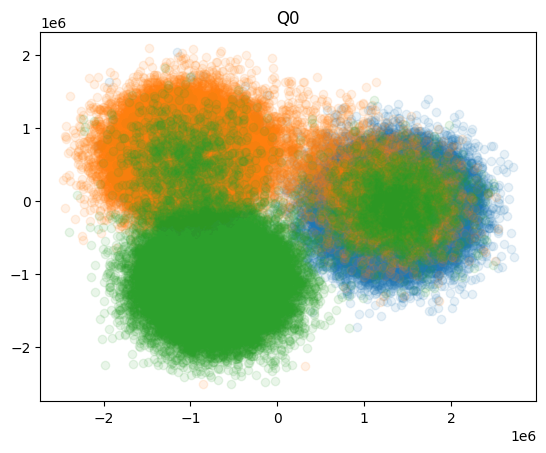

In [5]:
Q0_0,Q0_1,Q0_2=dataQ0[0,:,1],dataQ0[1,:,1],dataQ0[2,:,1]
H0_0,H0_1,H0_2=dataQ0[0,:,0],dataQ0[1,:,0],dataQ0[2,:,0]
plt.scatter(Q0_0.real,Q0_0.imag,alpha=0.1,label='|0>')
plt.scatter(Q0_1.real,Q0_1.imag,alpha=0.1,label='|1>')
plt.scatter(Q0_2.real,Q0_2.imag,alpha=0.1,label='|2>')
plt.title('Q0')
plt.show()

# plt.scatter(H0_0.real,H0_0.imag,alpha=0.1)
# plt.scatter(H0_1.real,H0_1.imag,alpha=0.1)
# plt.scatter(H0_2.real,H0_2.imag,alpha=0.1)
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

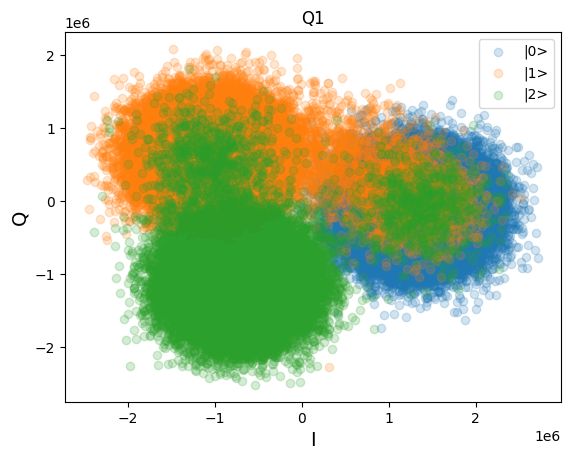

In [18]:
hq0_0=Q0_0[H0_0.real>0]
hq0_1=Q0_1[H0_1.real>0]
hq0_2=Q0_2[H0_2.real>0]
plt.scatter(hq0_0.real,hq0_0.imag,alpha=0.2,label='|0>')
plt.scatter(hq0_1.real,hq0_1.imag,alpha=0.2,label='|1>')
plt.scatter(hq0_2.real,hq0_2.imag,alpha=0.2,label='|2>')
plt.title('Q1')
plt.legend()
plt.xlabel('I' ,size=14)
plt.ylabel('Q' ,size=14)
plt.savefig('qutrit.png',dpi=300)
plt.show




In [7]:
np.save('../Data/ML/031924/state0.npy',np.stack((hq0_0.real,hq0_0.imag),axis=1))
np.save('../Data/ML/031924/state1.npy',np.stack((hq0_1.real,hq0_1.imag),axis=1))
np.save('../Data/ML/031924/state2.npy',np.stack((hq0_2.real,hq0_2.imag),axis=1))
